In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_circles
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL

from utils import  (evaluate_model, poly_kernel, gauss_kernel, scoring,
                    DATA_CMAP, DATA_COLORS, DATA_MARKERS, plot_e_a_mu)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

Populating the interactive namespace from numpy and matplotlib


$k_{rbf}(x_1, x_2) = \exp\left(\frac{-\Vert x_1 - x_2 \Vert^2}{\sigma}\right); \sigma \in [-3, \dots, 6] \wedge \sigma \in \mathbb{Z}$

$k_{poly}(x_1, x_2) = (\left\langle x_1, x_2 \right\rangle + 1)^d; b \in [1, \dots, 3] \wedge b \in \mathbb{Z}$

In [2]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Noisy Data

In [3]:
X, y = make_circles(N, noise=0.3, factor=0.3)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y
display(data.head())
data.describe()

,x1,x2,y
0,-1.099249,-0.984553,-1
1,0.038206,-0.699495,1
2,0.144306,-0.829935,-1
3,0.400684,0.887127,-1
4,0.093034,-0.287399,1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,0.016842,0.000065,0.0000
std,0.600060,0.607730,1.0005
min,-1.912339,-1.844214,-1.0000
25%,-0.387290,-0.411905,-1.0000
50%,0.032752,0.019780,0.0000
75%,0.436042,0.394384,1.0000
max,1.752335,1.769175,1.0000


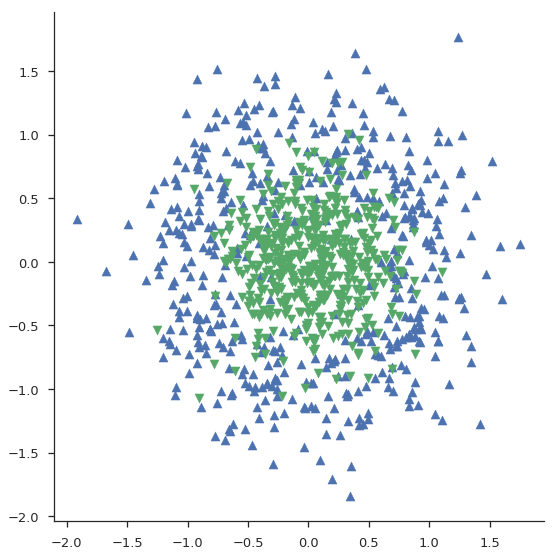

In [4]:
ax = plt.figure(figsize=(8, 8)).gca()
ax.scatter(data.x1[data.y==-1], data.x2[data.y==-1],
           c=DATA_COLORS[0], marker=DATA_MARKERS[0])
ax.scatter(data.x1[data.y==1], data.x2[data.y==1],
           c=DATA_COLORS[1], marker=DATA_MARKERS[1])
sns.despine()
plt.tight_layout()

## Sparse Model

0 - Kernels: 3/39 (0.07692307692307693). SV: 663/666 (0.9954954954954955). Mean e: 0.0508. Median e: -0.0000. Std e: 0.1756. 
1 - Kernels: 1/39 (0.02564102564102564). SV: 663/666 (0.9954954954954955). Mean e: 0.0470. Median e: 0.0000. Std e: 0.2894. 
2 - Kernels: 1/39 (0.02564102564102564). SV: 667/668 (0.9985029940119761). Mean e: 0.0465. Median e: -0.0000. Std e: 0.2867. 
3 - Kernels: 3/39 (0.07692307692307693). SV: 666/666 (1.0). Mean e: 0.0469. Median e: 0.0001. Std e: 0.2878. 
4 - Kernels: 1/39 (0.02564102564102564). SV: 663/666 (0.9954954954954955). Mean e: 0.0473. Median e: -0.0000. Std e: 0.2916. 
5 - Kernels: 3/39 (0.07692307692307693). SV: 668/668 (1.0). Mean e: 0.0487. Median e: 0.0000. Std e: 0.1685. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 12.6095,  14.7297,  12.2828,  11.8547,  11.5518,  11.8266]),
 'score_time': array([ 1.3304,  1.6499,  1.3465,  1.3313,  1.3222,  1.3234]),
 'test_score': array([ 0.8473,  0.8772,  0.8825,  0.8832,  0.8563,  0.8584]),
 'train_score': array([ 0.8844,  0.8724,  0.8668,  0.8754,  0.8619,  0.8937])}

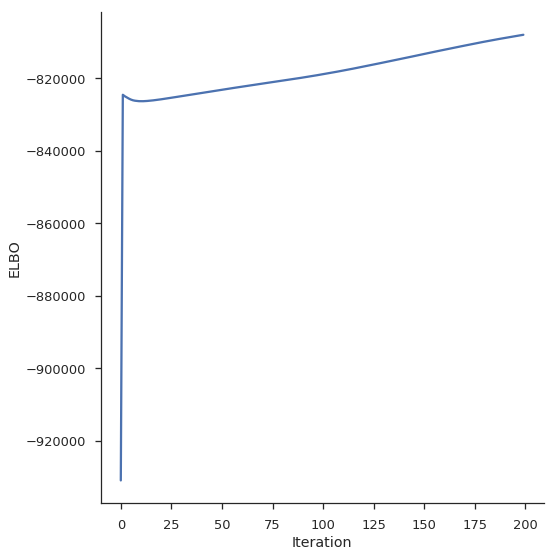

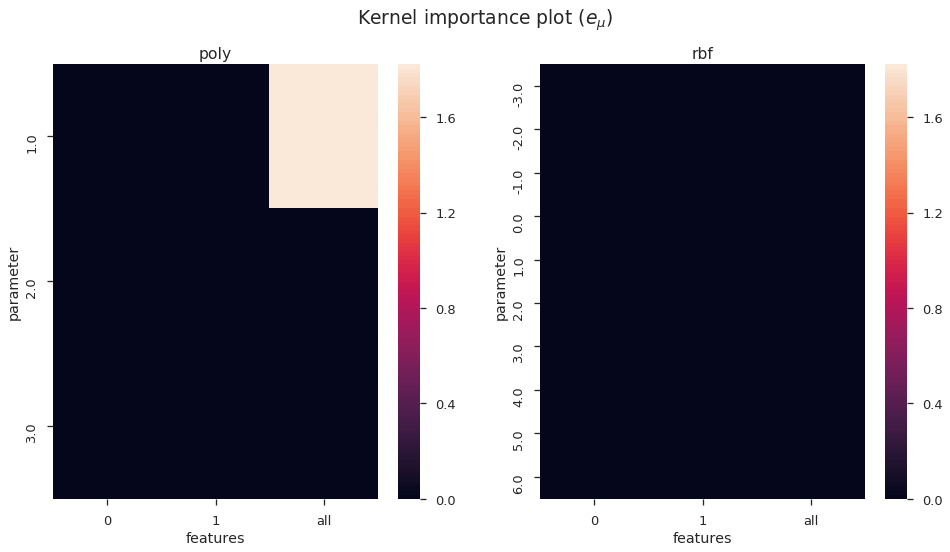

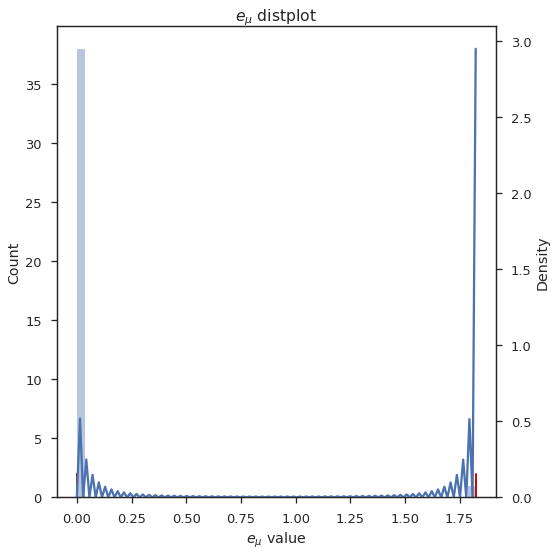

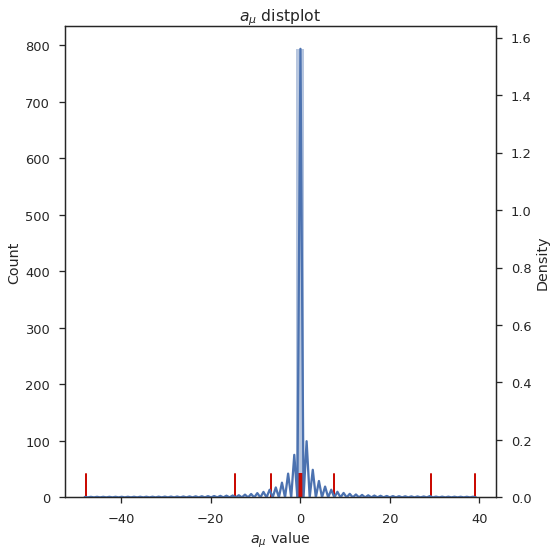

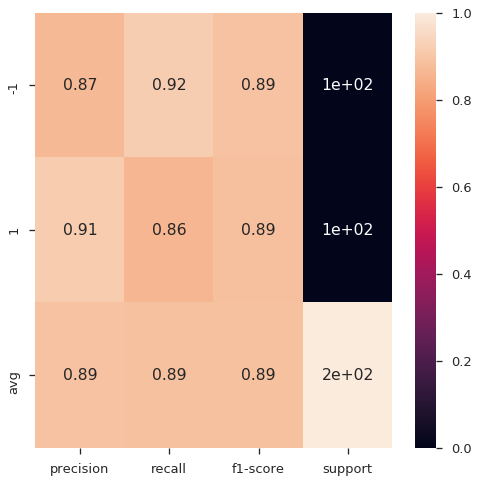

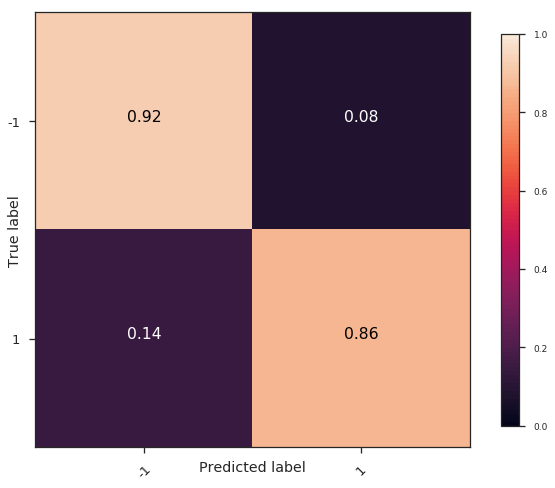

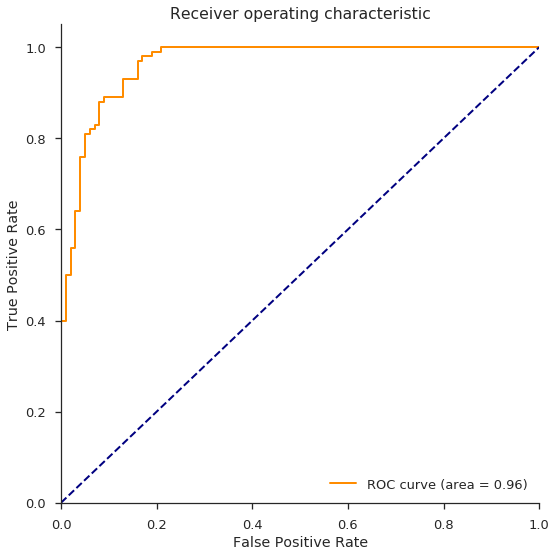

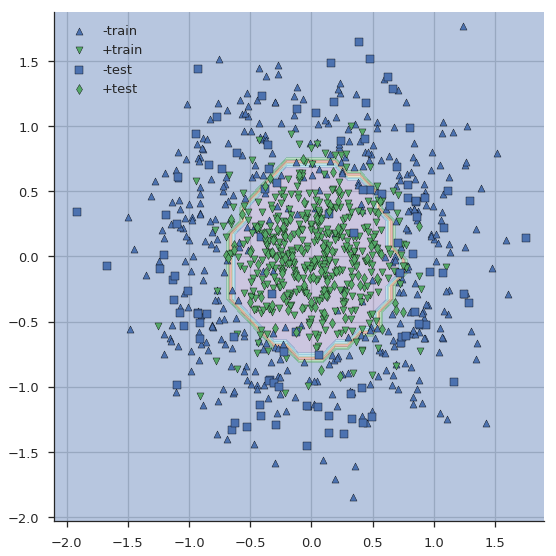

In [5]:
cn_sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)

evaluate_model(cn_sparse_model, X, y, kernel_attrs)

## Dense Model

0 - Kernels: 39/39 (1.0). SV: 663/666 (0.9954954954954955). Mean e: 0.0553. Median e: -0.0019. Std e: 0.1515. 
1 - Kernels: 39/39 (1.0). SV: 663/666 (0.9954954954954955). Mean e: 0.0815. Median e: 0.0562. Std e: 0.1535. 
2 - Kernels: 39/39 (1.0). SV: 665/668 (0.9955089820359282). Mean e: 0.0643. Median e: 0.0144. Std e: 0.1530. 
3 - Kernels: 39/39 (1.0). SV: 665/666 (0.9984984984984985). Mean e: 0.0810. Median e: 0.0360. Std e: 0.1527. 
4 - Kernels: 39/39 (1.0). SV: 662/666 (0.993993993993994). Mean e: 0.0070. Median e: -0.0377. Std e: 0.1656. 
5 - Kernels: 39/39 (1.0). SV: 662/668 (0.9910179640718563). Mean e: 0.0570. Median e: -0.0059. Std e: 0.1577. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 13.0645,  13.6781,  26.7243,  13.9657,  31.9493,  27.7722]),
 'score_time': array([ 1.3797,  2.1685,  1.8817,  1.4224,  1.931 ,  1.937 ]),
 'test_score': array([ 0.8832,  0.8743,  0.8614,  0.8653,  0.8743,  0.8675]),
 'train_score': array([ 0.8739,  0.8724,  0.8728,  0.8784,  0.8799,  0.8728])}

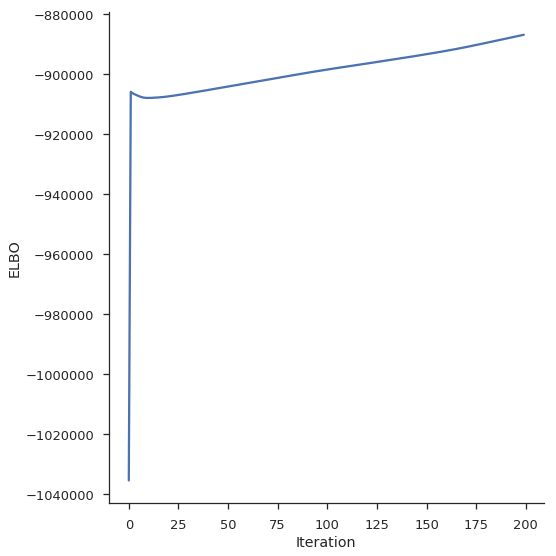

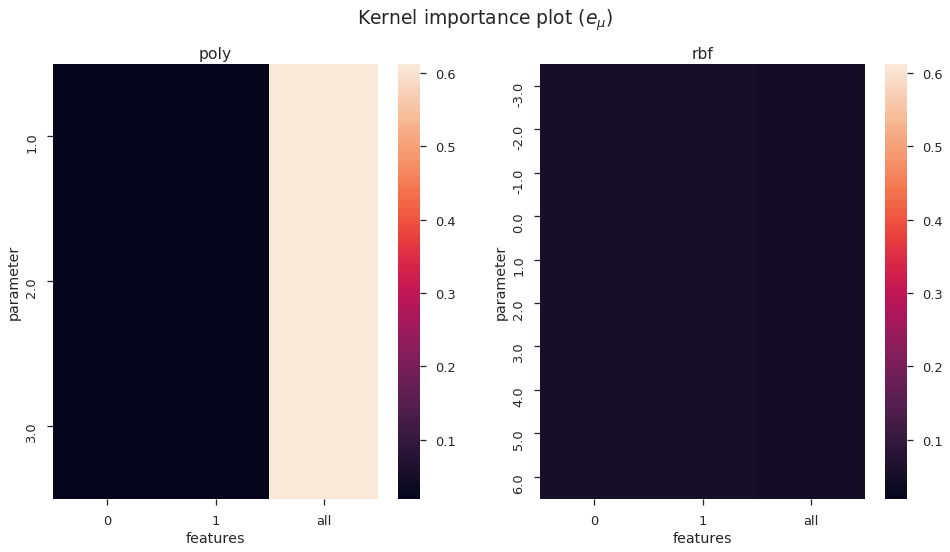

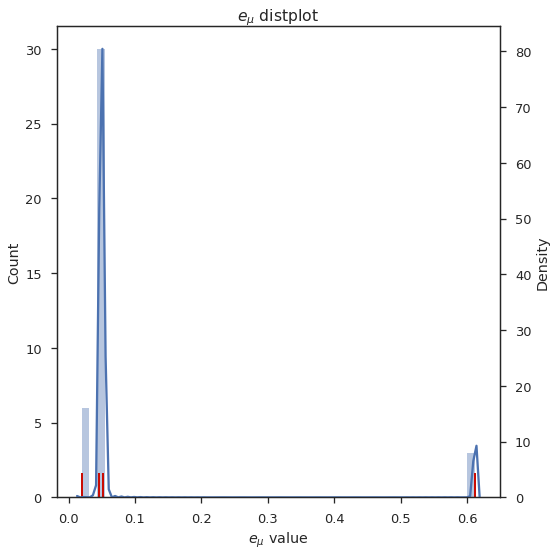

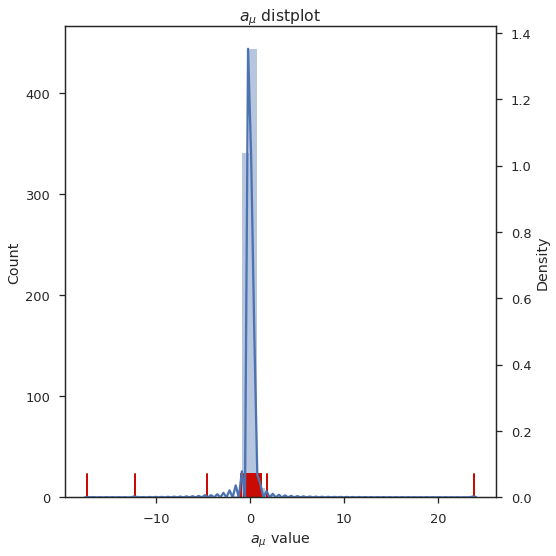

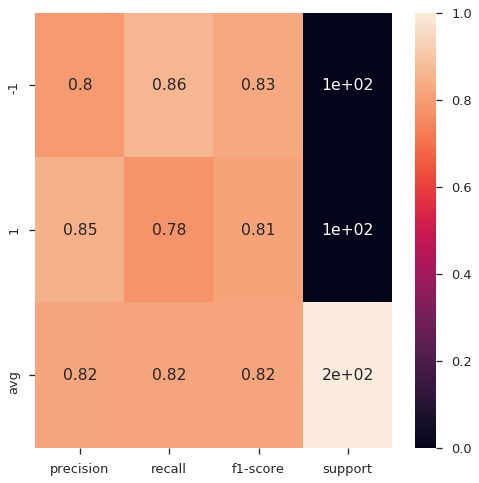

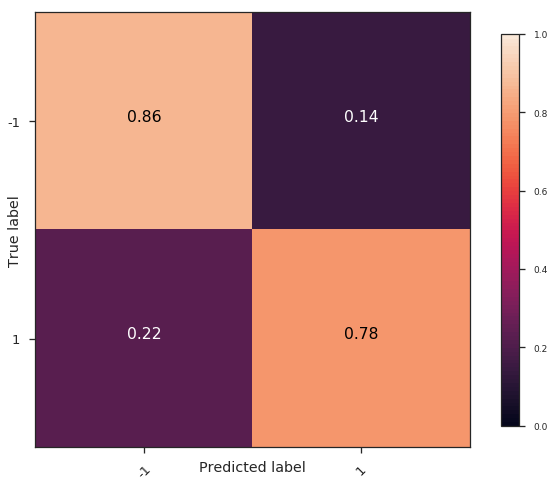

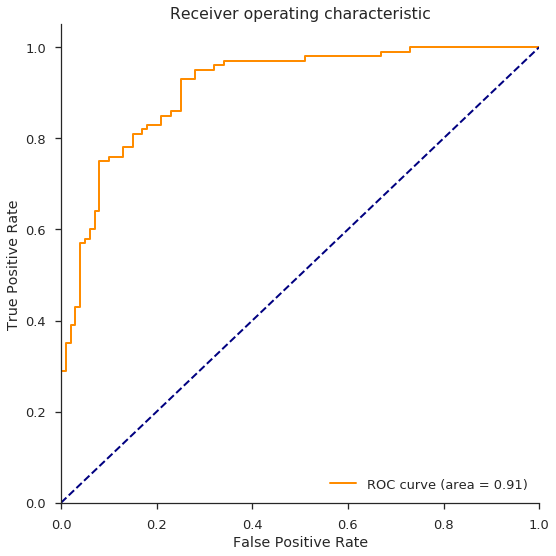

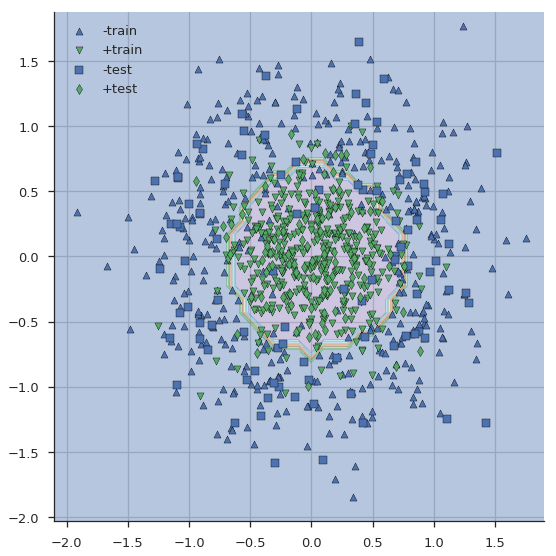

In [6]:
cn_normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1, beta_omega=1,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cn_normal_model, X, y, kernel_attrs)

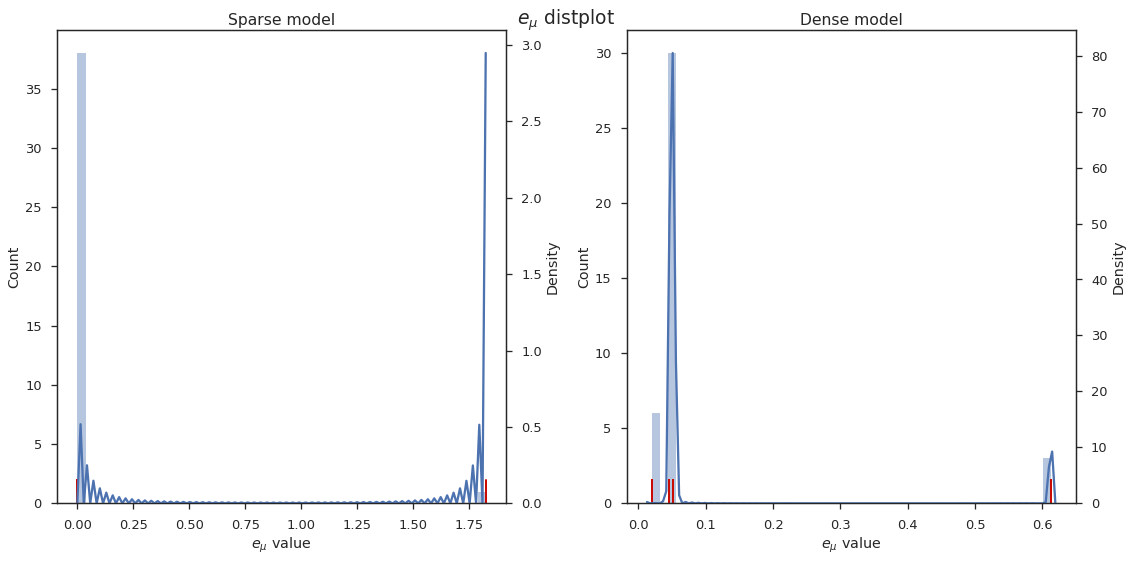

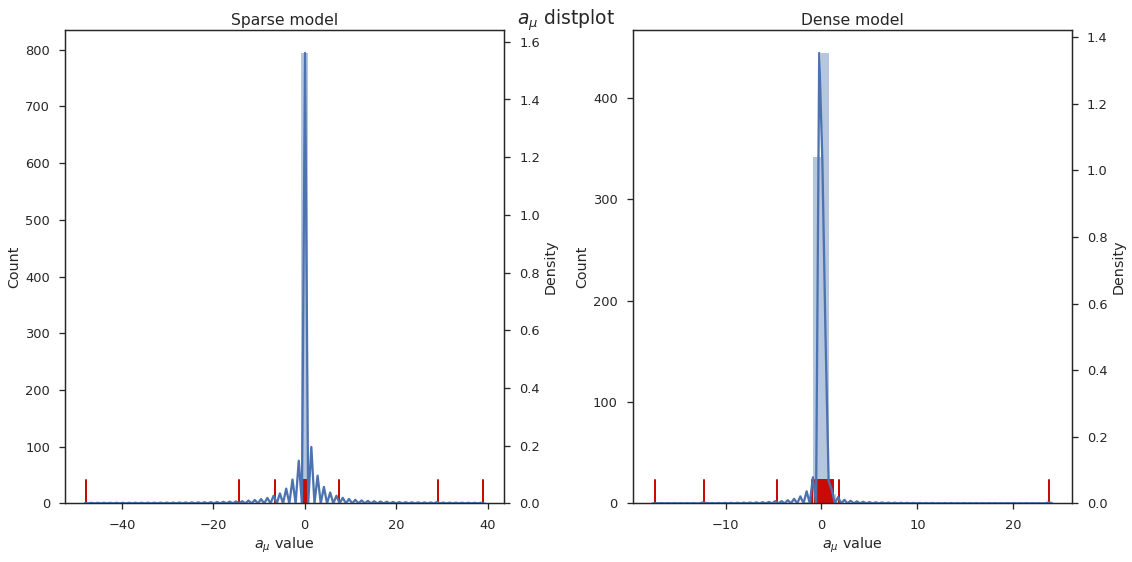

In [7]:
plot_e_a_mu(cn_sparse_model, cn_normal_model,
            'Sparse model', 'Dense model')